# Image Generation with Tiny-SD and OpenVINO™

In recent times, the AI community has witnessed a remarkable surge in the development of larger and more performant language models, such as Falcon 40B, LLaMa-2 70B, Falcon 40B, MPT 30B, and in the imaging domain with models like SD2.1 and SDXL. These advancements have undoubtedly pushed the boundaries of what AI can achieve, enabling highly versatile and state-of-the-art image generation and language understanding capabilities. However, the breakthrough of large models comes with substantial computational demands. To resolve this issue, recent research on efficient Stable Diffusion has prioritized reducing the number of sampling steps and utilizing network quantization.

Moving towards the goal of making image generative models faster, smaller, and cheaper, Tiny-SD was proposed by Segmind. Tiny SD is a compressed Stable Diffusion model that has been trained on Knowledge-Distillation (KD) techniques and the work has been largely based on this [paper](https://arxiv.org/pdf/2305.15798.pdf). The authors describe a Block-removal Knowledge-Distillation method where some of the UNet layers are removed and the student model weights are trained. Using the KD methods described in the paper, they were able to train two compressed models using the 🧨 diffusers library; Small and Tiny, that have 35% and 55% fewer parameters, respectively than the base model while achieving comparable image fidelity as the base model. More details about model can be found in [model card](https://huggingface.co/segmind/tiny-sd), [blog post](https://huggingface.co/blog/sd_distillation) and training [repository](https://github.com/segmind/distill-sd).

This notebook demonstrates how to convert and run the Tiny-SD model using OpenVINO.

The notebook contains the following steps:

1. Convert PyTorch models to OpenVINO Intermediate Representation using OpenVINO Converter Tool (OVC).
2. Prepare Inference Pipeline.
3. Run Inference pipeline with OpenVINO.
4. Run Interactive demo for Tiny-SD model


### Table of content:
- [Prerequisites](#Prerequisites)
- [Create PyTorch Models pipeline](#Create-PyTorch-Models-pipeline)
- [Convert models to OpenVINO Intermediate representation (IR) format](#Convert-models-to-OpenVINO-Intermediate-representation-format)
    - [Text Encoder](#Text-Encoder)
    - [U-net](#U-net)
    - [VAE](#VAE)
- [Prepare Inference Pipeline](#Prepare-Inference-Pipeline)
- [Configure Inference Pipeline](#Configure-Inference-Pipeline)
    - [Text-to-Image generation](#Text-to-Image-generation)
    - [Image-to-Image generation](#Image-to-Image-generation)

## Prerequisites

Install required dependencies

In [ ]:
!pip install -q "openvino==2023.1.0.dev20230728" "diffusers>=0.18.0" "transformers>=4.30.2" "gradio"

## Create PyTorch Models pipeline
`StableDiffusionPipeline` is an end-to-end inference pipeline that you can use to generate images from text with just a few lines of code.

First, load the pre-trained weights of all components of the model.

In [2]:
import gc
from diffusers import StableDiffusionPipeline

model_id = "segmind/tiny-sd"

pipe = StableDiffusionPipeline.from_pretrained(model_id).to("cpu")
text_encoder = pipe.text_encoder
text_encoder.eval()
unet = pipe.unet
unet.eval()
vae = pipe.vae
vae.eval()

del pipe
gc.collect()

2023-08-16 14:31:04.983972: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-16 14:31:05.021824: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-16 14:31:05.601710: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
vae/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

31

## Convert models to OpenVINO Intermediate representation format

OpenVINO supports PyTorch through conversion to OpenVINO Intermediate Representation (IR) format.  To take the advantage of OpenVINO optimization tools and features, the model should be converted using the OpenVINO Converter tool (OVC). The `openvino.convert_model` function provides Python API for OVC usage. The function returns the instance of the OpenVINO Model class, which is ready for use in the Python interface. However, it can also be saved on disk using `openvino.save_model` for future execution.

Starting from OpenVINO 2023.0.0 release OpenVINO supports direct conversion PyTorch models. To perform conversion, we should provide PyTorch model instance and example input into `openvino.convert_model`. By default, model converted with dynamic shapes preserving, in order to fixate input shape to generate image of specific resolution, `input` parameter additionally can be specified.

The model consists of three important parts:

* Text Encoder for creation condition to generate image from text prompt.
* U-net for step by step denoising latent image representation.
* Autoencoder (VAE) for encoding input image to latent space (if required) and decoding latent space to image back after generation.

Let us convert each part.

### Text Encoder

The text-encoder is responsible for transforming the input prompt, for example, "a photo of an astronaut riding a horse" into an embedding space that can be understood by the U-Net. It is usually a simple transformer-based encoder that maps a sequence of input tokens to a sequence of latent text embeddings.

Input of the text encoder is the tensor `input_ids` which contains indexes of tokens from text processed by tokenizer and padded to maximum length accepted by model. Model outputs are two tensors: `last_hidden_state` - hidden state from the last MultiHeadAttention layer in the model and `pooler_out` - Pooled output for whole model hidden states.

In [3]:
from pathlib import Path
import torch
from openvino import convert_model, save_model

TEXT_ENCODER_OV_PATH = Path("text_encoder.xml")


def convert_encoder(text_encoder: torch.nn.Module, ir_path:Path):
    """
    Convert Text Encoder mode. 
    Function accepts text encoder model, and prepares example inputs for conversion, 
    Parameters: 
        text_encoder (torch.nn.Module): text_encoder model from Stable Diffusion pipeline
        ir_path (Path): File for storing model
    Returns:
        None
    """
    input_ids = torch.ones((1, 77), dtype=torch.long)
    # switch model to inference mode
    text_encoder.eval()

    # disable gradients calculation for reducing memory consumption
    with torch.no_grad():
        # Export model to IR format
        ov_model = convert_model(text_encoder, example_input=input_ids, input=[(1,77),])
        save_model(ov_model, ir_path)
        print(f'Text Encoder successfully converted to IR and saved to {ir_path}')
    

if not TEXT_ENCODER_OV_PATH.exists():
    convert_encoder(text_encoder, TEXT_ENCODER_OV_PATH)
else:
    print(f"Text encoder will be loaded from {TEXT_ENCODER_OV_PATH}")

del text_encoder
gc.collect()

Text encoder will be loaded from text_encoder.xml


0

### U-net

U-net model has three inputs:

* `sample` - latent image sample from previous step. Generation process has not been started yet, so you will use random noise.
* `timestep` - current scheduler step.
* `encoder_hidden_state` - hidden state of text encoder.

Model predicts the `sample` state for the next step.

In [4]:
import numpy as np
from openvino import PartialShape, Type

UNET_OV_PATH = Path('unet.xml')

dtype_mapping = {
    torch.float32: Type.f32,
    torch.float64: Type.f64
}


def convert_unet(unet:torch.nn.Module, ir_path:Path):
    """
    Convert U-net model to IR format. 
    Function accepts unet model, prepares example inputs for conversion, 
    Parameters: 
        unet (StableDiffusionPipeline): unet from Stable Diffusion pipeline
        ir_path (Path): File for storing model
    Returns:
        None
    """
    # prepare inputs
    encoder_hidden_state = torch.ones((2, 77, 768))
    latents_shape = (2, 4, 512 // 8, 512 // 8)
    latents = torch.randn(latents_shape)
    t = torch.from_numpy(np.array(1, dtype=float))
    dummy_inputs = (latents, t, encoder_hidden_state)
    input_info = []
    for input_tensor in dummy_inputs:
        shape = PartialShape(tuple(input_tensor.shape))
        element_type = dtype_mapping[input_tensor.dtype]
        input_info.append((shape, element_type))

    unet.eval()

    with torch.no_grad():
        ov_model = convert_model(unet, example_input=dummy_inputs)
        save_model(ov_model, ir_path)
    print(f'Unet successfully converted to IR and saved to {ir_path}')


if not UNET_OV_PATH.exists():
    convert_unet(unet, UNET_OV_PATH)
    gc.collect()
else:
    print(f"Unet will be loaded from {UNET_OV_PATH}")
del unet
gc.collect()

Unet will be loaded from unet.xml


0

### VAE

The VAE model has two parts, an encoder and a decoder. The encoder is used to convert the image into a low dimensional latent representation, which will serve as the input to the U-Net model. The decoder, conversely, transforms the latent representation back into an image.

During latent diffusion training, the encoder is used to get the latent representations (latents) of the images for the forward diffusion process, which applies more and more noise at each step. During inference, the denoised latents generated by the reverse diffusion process are converted back into images using the VAE decoder. When you run inference for text-to-image, there is no initial image as a starting point. You can skip this step and directly generate initial random noise.

As the encoder and the decoder are used independently in different parts of the pipeline, it will be better to convert them to separate models.

In [5]:
VAE_ENCODER_OV_PATH = Path("vae_encodr.xml")

def convert_vae_encoder(vae: torch.nn.Module, ir_path: Path):
    """
    Convert VAE model for encoding to IR format. 
    Function accepts vae model, creates wrapper class for export only necessary for inference part, 
    prepares example inputs for conversion, 
    Parameters: 
        vae (torch.nn.Module): VAE model from StableDiffusio pipeline 
        ir_path (Path): File for storing model
    Returns:
        None
    """
    class VAEEncoderWrapper(torch.nn.Module):
        def __init__(self, vae):
            super().__init__()
            self.vae = vae

        def forward(self, image):
            return self.vae.encode(x=image)["latent_dist"].sample()
    vae_encoder = VAEEncoderWrapper(vae)
    vae_encoder.eval()
    image = torch.zeros((1, 3, 512, 512))
    with torch.no_grad():
        ov_model = convert_model(vae_encoder, example_input=image, input=[((1,3,512,512),)])
        save_model(ov_model, ir_path)
    print(f'VAE encoder successfully converted to IR and saved to {ir_path}')


if not VAE_ENCODER_OV_PATH.exists():
    convert_vae_encoder(vae, VAE_ENCODER_OV_PATH)
else:
    print(f"VAE encoder will be loaded from {VAE_ENCODER_OV_PATH}")

VAE_DECODER_OV_PATH = Path('vae_decoder.xml')

def convert_vae_decoder(vae: torch.nn.Module, ir_path: Path):
    """
    Convert VAE model for decoding to IR format. 
    Function accepts vae model, creates wrapper class for export only necessary for inference part, 
    prepares example inputs for conversion, 
    Parameters: 
        vae (torch.nn.Module): VAE model frm StableDiffusion pipeline
        ir_path (Path): File for storing model
    Returns:
        None
    """
    class VAEDecoderWrapper(torch.nn.Module):
        def __init__(self, vae):
            super().__init__()
            self.vae = vae

        def forward(self, latents):
            return self.vae.decode(latents)
    
    vae_decoder = VAEDecoderWrapper(vae)
    latents = torch.zeros((1, 4, 64, 64))

    vae_decoder.eval()
    with torch.no_grad():
        ov_model = convert_model(vae_decoder, example_input=latents, input=[((1,4,64,64),)])
        save_model(ov_model, ir_path)
    print(f'VAE decoder successfully converted to IR and saved to {ir_path}')


if not VAE_DECODER_OV_PATH.exists():
    convert_vae_decoder(vae, VAE_DECODER_OV_PATH)
else:
    print(f"VAE decoder will be loaded from {VAE_DECODER_OV_PATH}")

del vae
gc.collect()

VAE encoder will be loaded from vae_encodr.xml
VAE decoder will be loaded from vae_decoder.xml


0

## Prepare Inference Pipeline

Putting it all together, let us now take a closer look at how the model works in inference by illustrating the logical flow.

![sd-pipeline](https://user-images.githubusercontent.com/29454499/260981188-c112dd0a-5752-4515-adca-8b09bea5d14a.png)

As you can see from the diagram, the only difference between Text-to-Image and text-guided Image-to-Image generation in approach is how initial latent state is generated. In case of Image-to-Image generation, you additionally have an image encoded by VAE encoder mixed with the noise produced by using latent seed, while in Text-to-Image you use only noise as initial latent state.
The stable diffusion model takes both a latent image representation of size $64 \times 64$ and a text prompt is transformed to text embeddings of size $77 \times 768$ via CLIP's text encoder as an input.

Next, the U-Net iteratively *denoises* the random latent image representations while being conditioned on the text embeddings. The output of the U-Net, being the noise residual, is used to compute a denoised latent image representation via a scheduler algorithm. Many different scheduler algorithms can be used for this computation, each having its pros and cons. For Stable Diffusion, it is recommended to use one of:

- [PNDM scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_pndm.py)
- [DDIM scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_ddim.py)
- [K-LMS scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_lms_discrete.py)(you will use it in your pipeline)

Theory on how the scheduler algorithm function works is out of scope for this notebook. Nonetheless, in short, you should remember that you compute the predicted denoised image representation from the previous noise representation and the predicted noise residual.
For more information, refer to the recommended [Elucidating the Design Space of Diffusion-Based Generative Models](https://arxiv.org/abs/2206.00364)

The *denoising* process is repeated given number of times (by default 50) to step-by-step retrieve better latent image representations.
When complete, the latent image representation is decoded by the decoder part of the variational auto encoder.

In [6]:
import inspect
from typing import List, Optional, Union, Dict

import PIL
import cv2

from transformers import CLIPTokenizer
from diffusers.pipeline_utils import DiffusionPipeline
from diffusers.schedulers import DDIMScheduler, LMSDiscreteScheduler, PNDMScheduler
from openvino.runtime import Model


def scale_fit_to_window(dst_width:int, dst_height:int, image_width:int, image_height:int):
    """
    Preprocessing helper function for calculating image size for resize with peserving original aspect ratio 
    and fitting image to specific window size
    
    Parameters:
      dst_width (int): destination window width
      dst_height (int): destination window height
      image_width (int): source image width
      image_height (int): source image height
    Returns:
      result_width (int): calculated width for resize
      result_height (int): calculated height for resize
    """
    im_scale = min(dst_height / image_height, dst_width / image_width)
    return int(im_scale * image_width), int(im_scale * image_height)


def preprocess(image: PIL.Image.Image):
    """
    Image preprocessing function. Takes image in PIL.Image format, resizes it to keep aspect ration and fits to model input window 512x512,
    then converts it to np.ndarray and adds padding with zeros on right or bottom side of image (depends from aspect ratio), after that
    converts data to float32 data type and change range of values from [0, 255] to [-1, 1], finally, converts data layout from planar NHWC to NCHW.
    The function returns preprocessed input tensor and padding size, which can be used in postprocessing.
    
    Parameters:
      image (PIL.Image.Image): input image
    Returns:
       image (np.ndarray): preprocessed image tensor
       meta (Dict): dictionary with preprocessing metadata info
    """
    src_width, src_height = image.size
    dst_width, dst_height = scale_fit_to_window(
        512, 512, src_width, src_height)
    image = np.array(image.resize((dst_width, dst_height),
                     resample=PIL.Image.Resampling.LANCZOS))[None, :]
    pad_width = 512 - dst_width
    pad_height = 512 - dst_height
    pad = ((0, 0), (0, pad_height), (0, pad_width), (0, 0))
    image = np.pad(image, pad, mode="constant")
    image = image.astype(np.float32) / 255.0
    image = 2.0 * image - 1.0
    image = image.transpose(0, 3, 1, 2)
    return image, {"padding": pad, "src_width": src_width, "src_height": src_height}


class OVStableDiffusionPipeline(DiffusionPipeline):
    def __init__(
        self,
        vae_decoder: Model,
        text_encoder: Model,
        tokenizer: CLIPTokenizer,
        unet: Model,
        scheduler: Union[DDIMScheduler, PNDMScheduler, LMSDiscreteScheduler],
        vae_encoder: Model = None,
    ):
        """
        Pipeline for text-to-image generation using Stable Diffusion.
        Parameters:
            vae (Model):
                Variational Auto-Encoder (VAE) Model to decode images to and from latent representations.
            text_encoder (Model):
                Frozen text-encoder. Stable Diffusion uses the text portion of
                [CLIP](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel), specifically
                the clip-vit-large-patch14(https://huggingface.co/openai/clip-vit-large-patch14) variant.
            tokenizer (CLIPTokenizer):
                Tokenizer of class CLIPTokenizer(https://huggingface.co/docs/transformers/v4.21.0/en/model_doc/clip#transformers.CLIPTokenizer).
            unet (Model): Conditional U-Net architecture to denoise the encoded image latents.
            scheduler (SchedulerMixin):
                A scheduler to be used in combination with unet to denoise the encoded image latents. Can be one of
                DDIMScheduler, LMSDiscreteScheduler, or PNDMScheduler.
        """
        super().__init__()
        self.scheduler = scheduler
        self.vae_decoder = vae_decoder
        self.vae_encoder = vae_encoder
        self.text_encoder = text_encoder
        self.unet = unet
        self._text_encoder_output = text_encoder.output(0)
        self._unet_output = unet.output(0)
        self._vae_d_output = vae_decoder.output(0)
        self._vae_e_output = vae_encoder.output(0) if vae_encoder is not None else None
        self.height = 512
        self.width = 512
        self.tokenizer = tokenizer

    def __call__(
        self,
        prompt: Union[str, List[str]],
        image: PIL.Image.Image = None,
        num_inference_steps: Optional[int] = 50,
        negative_prompt: Union[str, List[str]] = None,
        guidance_scale: Optional[float] = 7.5,
        eta: Optional[float] = 0.0,
        output_type: Optional[str] = "pil",
        seed: Optional[int] = None,
        strength: float = 1.0,
        gif: Optional[bool] = False,
        **kwargs,
    ):
        """
        Function invoked when calling the pipeline for generation.
        Parameters:
            prompt (str or List[str]):
                The prompt or prompts to guide the image generation.
            image (PIL.Image.Image, *optional*, None):
                 Intinal image for generation.
            num_inference_steps (int, *optional*, defaults to 50):
                The number of denoising steps. More denoising steps usually lead to a higher quality image at the
                expense of slower inference.
            negative_prompt (str or List[str]):
                The negative prompt or prompts to guide the image generation.
            guidance_scale (float, *optional*, defaults to 7.5):
                Guidance scale as defined in Classifier-Free Diffusion Guidance(https://arxiv.org/abs/2207.12598).
                guidance_scale is defined as `w` of equation 2.
                Higher guidance scale encourages to generate images that are closely linked to the text prompt,
                usually at the expense of lower image quality.
            eta (float, *optional*, defaults to 0.0):
                Corresponds to parameter eta (η) in the DDIM paper: https://arxiv.org/abs/2010.02502. Only applies to
                [DDIMScheduler], will be ignored for others.
            output_type (`str`, *optional*, defaults to "pil"):
                The output format of the generate image. Choose between
                [PIL](https://pillow.readthedocs.io/en/stable/): PIL.Image.Image or np.array.
            seed (int, *optional*, None):
                Seed for random generator state initialization.
            gif (bool, *optional*, False):
                Flag for storing all steps results or not.
        Returns:
            Dictionary with keys: 
                sample - the last generated image PIL.Image.Image or np.array
                iterations - *optional* (if gif=True) images for all diffusion steps, List of PIL.Image.Image or np.array.
        """
        if seed is not None:
            np.random.seed(seed)

        img_buffer = []
        do_classifier_free_guidance = guidance_scale > 1.0
        # get prompt text embeddings
        text_embeddings = self._encode_prompt(prompt, do_classifier_free_guidance=do_classifier_free_guidance, negative_prompt=negative_prompt)
        
        # set timesteps
        accepts_offset = "offset" in set(inspect.signature(self.scheduler.set_timesteps).parameters.keys())
        extra_set_kwargs = {}
        if accepts_offset:
            extra_set_kwargs["offset"] = 1

        self.scheduler.set_timesteps(num_inference_steps, **extra_set_kwargs)
        timesteps, num_inference_steps = self.get_timesteps(num_inference_steps, strength)
        latent_timestep = timesteps[:1]

        # get the initial random noise unless the user supplied it
        latents, meta = self.prepare_latents(image, latent_timestep)

        # prepare extra kwargs for the scheduler step, since not all schedulers have the same signature
        # eta (η) is only used with the DDIMScheduler, it will be ignored for other schedulers.
        # eta corresponds to η in DDIM paper: https://arxiv.org/abs/2010.02502
        # and should be between [0, 1]
        accepts_eta = "eta" in set(inspect.signature(self.scheduler.step).parameters.keys())
        extra_step_kwargs = {}
        if accepts_eta:
            extra_step_kwargs["eta"] = eta

        for i, t in enumerate(self.progress_bar(timesteps)):
            # expand the latents if you are doing classifier free guidance
            latent_model_input = np.concatenate([latents] * 2) if do_classifier_free_guidance else latents
            latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

            # predict the noise residual
            noise_pred = self.unet([latent_model_input, t, text_embeddings])[self._unet_output]
            # perform guidance
            if do_classifier_free_guidance:
                noise_pred_uncond, noise_pred_text = noise_pred[0], noise_pred[1]
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            latents = self.scheduler.step(torch.from_numpy(noise_pred), t, torch.from_numpy(latents), **extra_step_kwargs)["prev_sample"].numpy()
            if gif:
                image = self.vae_decoder(latents * (1 / 0.18215))[self._vae_d_output]
                image = self.postprocess_image(image, meta, output_type)
                img_buffer.extend(image)

        # scale and decode the image latents with vae
        image = self.vae_decoder(latents * (1 / 0.18215))[self._vae_d_output]

        image = self.postprocess_image(image, meta, output_type)
        return {"sample": image, 'iterations': img_buffer}
    
    def _encode_prompt(self, prompt:Union[str, List[str]], num_images_per_prompt:int = 1, do_classifier_free_guidance:bool = True, negative_prompt:Union[str, List[str]] = None):
        """
        Encodes the prompt into text encoder hidden states.

        Parameters:
            prompt (str or list(str)): prompt to be encoded
            num_images_per_prompt (int): number of images that should be generated per prompt
            do_classifier_free_guidance (bool): whether to use classifier free guidance or not
            negative_prompt (str or list(str)): negative prompt to be encoded
        Returns:
            text_embeddings (np.ndarray): text encoder hidden states
        """
        batch_size = len(prompt) if isinstance(prompt, list) else 1

        # tokenize input prompts
        text_inputs = self.tokenizer(
            prompt,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            truncation=True,
            return_tensors="np",
        )
        text_input_ids = text_inputs.input_ids

        text_embeddings = self.text_encoder(
            text_input_ids)[self._text_encoder_output]

        # duplicate text embeddings for each generation per prompt
        if num_images_per_prompt != 1:
            bs_embed, seq_len, _ = text_embeddings.shape
            text_embeddings = np.tile(
                text_embeddings, (1, num_images_per_prompt, 1))
            text_embeddings = np.reshape(
                text_embeddings, (bs_embed * num_images_per_prompt, seq_len, -1))

        # get unconditional embeddings for classifier free guidance
        if do_classifier_free_guidance:
            uncond_tokens: List[str]
            max_length = text_input_ids.shape[-1]
            if negative_prompt is None:
                uncond_tokens = [""] * batch_size
            elif isinstance(negative_prompt, str):
                uncond_tokens = [negative_prompt]
            else:
                uncond_tokens = negative_prompt
            uncond_input = self.tokenizer(
                uncond_tokens,
                padding="max_length",
                max_length=max_length,
                truncation=True,
                return_tensors="np",
            )

            uncond_embeddings = self.text_encoder(uncond_input.input_ids)[self._text_encoder_output]

            # duplicate unconditional embeddings for each generation per prompt, using mps friendly method
            seq_len = uncond_embeddings.shape[1]
            uncond_embeddings = np.tile(uncond_embeddings, (1, num_images_per_prompt, 1))
            uncond_embeddings = np.reshape(uncond_embeddings, (batch_size * num_images_per_prompt, seq_len, -1))

            # For classifier free guidance, we need to do two forward passes.
            # Here we concatenate the unconditional and text embeddings into a single batch
            # to avoid doing two forward passes
            text_embeddings = np.concatenate([uncond_embeddings, text_embeddings])

        return text_embeddings


    def prepare_latents(self, image:PIL.Image.Image = None, latent_timestep:torch.Tensor = None):
        """
        Function for getting initial latents for starting generation
        
        Parameters:
            image (PIL.Image.Image, *optional*, None):
                Input image for generation, if not provided randon noise will be used as starting point
            latent_timestep (torch.Tensor, *optional*, None):
                Predicted by scheduler initial step for image generation, required for latent image mixing with nosie
        Returns:
            latents (np.ndarray):
                Image encoded in latent space
        """
        latents_shape = (1, 4, self.height // 8, self.width // 8)
        noise = np.random.randn(*latents_shape).astype(np.float32)
        if image is None:
            # if you use LMSDiscreteScheduler, let's make sure latents are multiplied by sigmas
            if isinstance(self.scheduler, LMSDiscreteScheduler):
                noise = noise * self.scheduler.sigmas[0].numpy()
                return noise, {}
        input_image, meta = preprocess(image)
        latents = self.vae_encoder(input_image)[self._vae_e_output] * 0.18215
        latents = self.scheduler.add_noise(torch.from_numpy(latents), torch.from_numpy(noise), latent_timestep).numpy()
        return latents, meta

    def postprocess_image(self, image:np.ndarray, meta:Dict, output_type:str = "pil"):
        """
        Postprocessing for decoded image. Takes generated image decoded by VAE decoder, unpad it to initila image size (if required), 
        normalize and convert to [0, 255] pixels range. Optionally, convertes it from np.ndarray to PIL.Image format
        
        Parameters:
            image (np.ndarray):
                Generated image
            meta (Dict):
                Metadata obtained on latents preparing step, can be empty
            output_type (str, *optional*, pil):
                Output format for result, can be pil or numpy
        Returns:
            image (List of np.ndarray or PIL.Image.Image):
                Postprocessed images
        """
        if "padding" in meta:
            pad = meta["padding"]
            (_, end_h), (_, end_w) = pad[1:3]
            h, w = image.shape[2:]
            unpad_h = h - end_h
            unpad_w = w - end_w
            image = image[:, :, :unpad_h, :unpad_w]
        image = np.clip(image / 2 + 0.5, 0, 1)
        image = np.transpose(image, (0, 2, 3, 1))
        # 9. Convert to PIL
        if output_type == "pil":
            image = self.numpy_to_pil(image)
            if "src_height" in meta:
                orig_height, orig_width = meta["src_height"], meta["src_width"]
                image = [img.resize((orig_width, orig_height),
                                    PIL.Image.Resampling.LANCZOS) for img in image]
        else:
            if "src_height" in meta:
                orig_height, orig_width = meta["src_height"], meta["src_width"]
                image = [cv2.resize(img, (orig_width, orig_width))
                         for img in image]
        return image

    def get_timesteps(self, num_inference_steps:int, strength:float):
        """
        Helper function for getting scheduler timesteps for generation
        In case of image-to-image generation, it updates number of steps according to strength
        
        Parameters:
           num_inference_steps (int):
              number of inference steps for generation
           strength (float):
               value between 0.0 and 1.0, that controls the amount of noise that is added to the input image. 
               Values that approach 1.0 enable lots of variations but will also produce images that are not semantically consistent with the input.
        """
        # get the original timestep using init_timestep
        init_timestep = min(int(num_inference_steps * strength), num_inference_steps)

        t_start = max(num_inference_steps - init_timestep, 0)
        timesteps = self.scheduler.timesteps[t_start:]

        return timesteps, num_inference_steps - t_start 

/tmp/ipykernel_1177743/625579901.py:8: FutureWarning: Importing `DiffusionPipeline` or `ImagePipelineOutput` from diffusers.pipeline_utils is deprecated. Please import from diffusers.pipelines.pipeline_utils instead.
  from diffusers.pipeline_utils import DiffusionPipeline


## Configure Inference Pipeline


First, you should create instances of OpenVINO Model.

In [7]:
from openvino.runtime import Core
core = Core()

Select device from dropdown list for running inference using OpenVINO.

In [8]:
import ipywidgets as widgets

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

In [9]:
text_enc = core.compile_model(TEXT_ENCODER_OV_PATH, device.value)

In [10]:
unet_model = core.compile_model(UNET_OV_PATH, device.value)

In [11]:
vae_decoder = core.compile_model(VAE_DECODER_OV_PATH, device.value)
vae_encoder = core.compile_model(VAE_ENCODER_OV_PATH, device.value)

Model tokenizer and scheduler are also important parts of the pipeline. Let us define them and put all components together

In [12]:
from transformers import CLIPTokenizer
from diffusers.schedulers import LMSDiscreteScheduler

lms = LMSDiscreteScheduler(
    beta_start=0.00085, 
    beta_end=0.012, 
    beta_schedule="scaled_linear"
)
tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-large-patch14')

ov_pipe = OVStableDiffusionPipeline(
    tokenizer=tokenizer,
    text_encoder=text_enc,
    unet=unet_model,
    vae_encoder=vae_encoder,
    vae_decoder=vae_decoder,
    scheduler=lms
)

### Text-to-Image generation

Now, let's see model in action

In [13]:
text_prompt = 'RAW studio photo of An intricate forest minitown landscape trapped in a bottle, atmospheric oliva lighting, on the table, intricate details, dark shot, soothing tones, muted colors '
seed = 431
num_steps = 20

In [14]:
print('Pipeline settings')
print(f'Input text: {text_prompt}')
print(f'Seed: {seed}')
print(f'Number of steps: {num_steps}')

Pipeline settings
Input text: RAW studio photo of An intricate forest minitown landscape trapped in a bottle, atmospheric oliva lighting, on the table, intricate details, dark shot, soothing tones, muted colors 
Seed: 431
Number of steps: 20


In [15]:
result = ov_pipe(text_prompt, num_inference_steps=num_steps, seed=seed)

  0%|          | 0/20 [00:00<?, ?it/s]

Finally, let us save generation results.
The pipeline returns several results: `sample` contains final generated image, `iterations` contains list of intermediate results for each step.

In [16]:
final_image = result['sample'][0]
final_image.save('result.png')

Now is show time!

Input text:
	RAW studio photo of An intricate forest minitown landscape trapped in a bottle, atmospheric oliva lighting, on the table, intricate details, dark shot, soothing tones, muted colors 


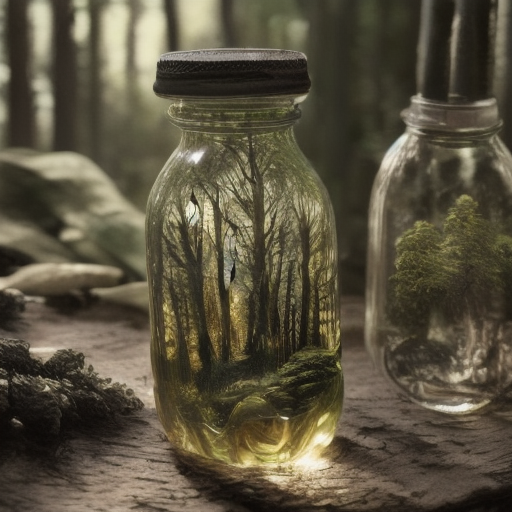

In [17]:
text = '\n\t'.join(text_prompt.split('.'))
print("Input text:")
print("\t" + text)
display(final_image)

Nice. As you can see, the picture has quite a high definition 🔥.

### Image-to-Image generation

One of the most amazing features of Stable Diffusion model is the ability to condition image generation from an existing image or sketch. Given a (potentially crude) image and the right text prompt, latent diffusion models can be used to “enhance” an image.

Image-to-Image generation, in additionally to the text prompt, requires providing the initial image. Optionally, you can also change `strength` parameter, which is a value between 0.0 and 1.0, that controls the amount of noise that is added to the input image. Values that approach 1.0 enable lots of variations but will also produce images that are not semantically consistent with the input. One of the interesting use cases for Image-to-Image generation is depainting - turning sketches or paintings into realistic photographs.

Additionally, to improve image generation quality, model supports negative prompting. Technically, positive prompt steers the diffusion toward the images associated with it, while negative prompt steers the diffusion away from it.In other words, negative prompt declares undesired concepts for generation image, e.g. if we want to have colorful and bright image, gray scale image will be result which we want to avoid, in this case gray scale can be treated as negative prompt. The positive and negative prompt are in equal footing. You can always use one with or without the other. More explanation of how it works can be found in this [article](https://stable-diffusion-art.com/how-negative-prompt-work/). 

In [18]:
text_prompt_i2i = 'professional photo portrait of woman, highly detailed, hyper realistic, cinematic effects, soft lighting'
negative_prompt_i2i = "blurry, poor quality, low res, worst quality, cropped, ugly, poorly drawn face, unreal, animate, poorly drawn eyes"
num_steps_i2i = 40
seed_i2i = 15
strength = 0.5

Pipeline settings
Input positive prompt: 
	professional photo portrait of woman, highly detailed, hyper realistic, cinematic effects, soft lighting
Input negative prompt: 
	blurry, poor quality, low res, worst quality, cropped, ugly, poorly drawn face, unreal, animate, poorly drawn eyes
Seed: 15
Number of steps: 40
Strength: 0.5
Input image:


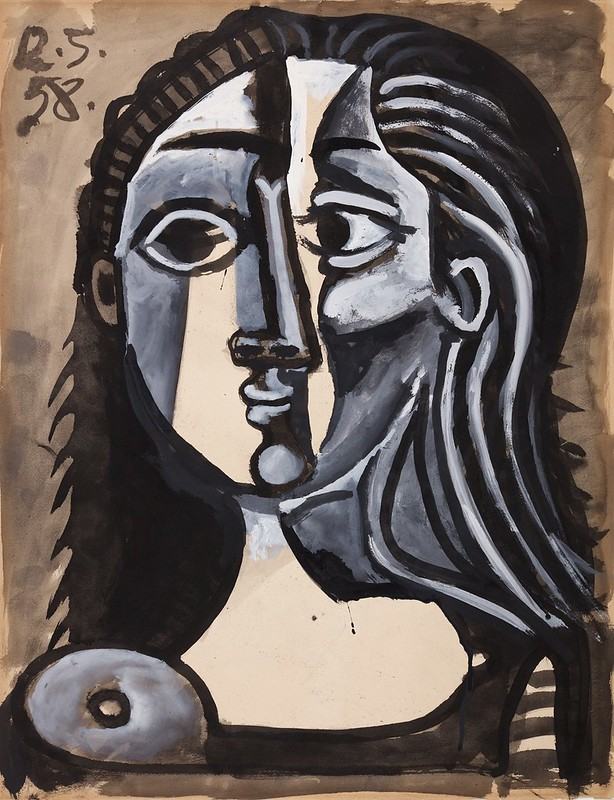

  0%|          | 0/20 [00:00<?, ?it/s]

In [19]:
from diffusers.utils import load_image

default_image_url = "https://user-images.githubusercontent.com/29454499/260418860-69cc443a-9ee6-493c-a393-3a97af080be7.jpg"
# read uploaded image
image = load_image(default_image_url)
print('Pipeline settings')
print(f'Input positive prompt: \n\t{text_prompt_i2i}')
print(f'Input negative prompt: \n\t{negative_prompt_i2i}')
print(f'Seed: {seed_i2i}')
print(f'Number of steps: {num_steps_i2i}')
print(f'Strength: {strength}')
print("Input image:")
display(image)
processed_image = ov_pipe(text_prompt_i2i, image, negative_prompt=negative_prompt_i2i, num_inference_steps=num_steps_i2i, seed=seed_i2i, strength=strength)

In [20]:
final_image_i2i = processed_image['sample'][0]
final_image_i2i.save('result_i2i.png')

Input text:
	professional photo portrait of woman, highly detailed, hyper realistic, cinematic effects, soft lighting


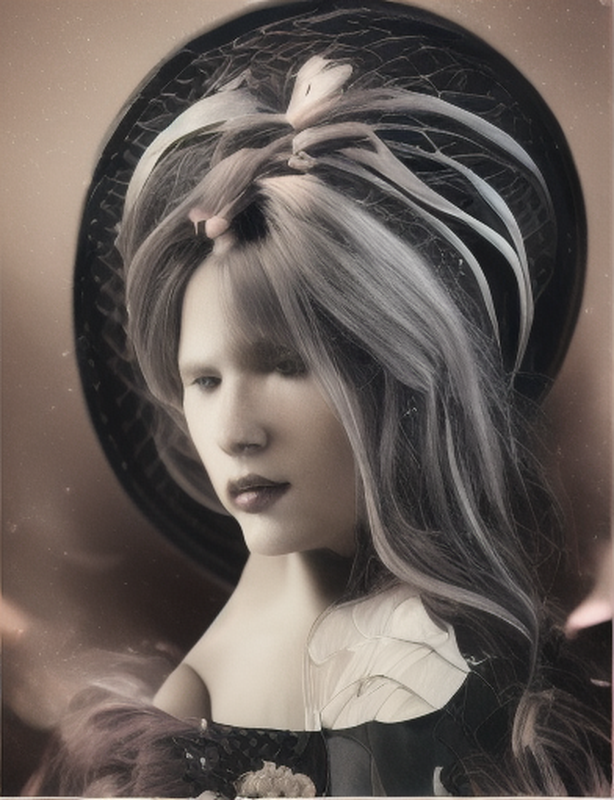

In [21]:
text_i2i = '\n\t'.join(text_prompt_i2i.split('.'))
print("Input text:")
print("\t" + text_i2i)
display(final_image_i2i)

### Interactive Demo

In [ ]:
import gradio as gr

sample_img_url = "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/tower.jpg"

img = load_image(sample_img_url).save("tower.jpg")

def generate_from_text(text, negative_text, seed, num_steps, _=gr.Progress(track_tqdm=True)):
    result = ov_pipe(text, negative_prompt=negative_text, num_inference_steps=num_steps, seed=seed)
    return result["sample"][0]


def generate_from_image(img, text, negative_text, seed, num_steps, strength, _=gr.Progress(track_tqdm=True)):
    result = ov_pipe(text, img, negative_prompt=negative_text, num_inference_steps=num_steps, seed=seed, strength=strength)
    return result["sample"][0]


with gr.Blocks() as demo:
    with gr.Tab("Text-to-Image generation"):
        with gr.Row():
            with gr.Column():
                text_input = gr.Textbox(lines=3, label="Positive prompt")
                negative_text_input = gr.Textbox(lines=3, label="Negative prompt")
                seed_input = gr.Slider(0, 10000000, value=751, label="Seed")
                steps_input = gr.Slider(1, 50, value=20, step=1, label="Steps")
            out = gr.Image(label="Result", type="pil")
        sample_text = "futuristic synthwave city, retro sunset, crystals, spires, volumetric lighting, studio Ghibli style, rendered in unreal engine with clean details"
        sample_text2 = "RAW studio photo of tiny cute happy  cat in a yellow raincoat in the woods, rain, a character portrait, soft lighting, high resolution, photo realistic, extremely detailed"
        negative_sample_text = ""
        negative_sample_text2 = "bad anatomy, blurry, noisy, jpeg artifacts, low quality, geometry, mutation, disgusting. ugly"
        btn = gr.Button()
        btn.click(generate_from_text, [text_input, negative_text_input, seed_input, steps_input], out)
        gr.Examples([[sample_text, negative_sample_text, 42, 20], [sample_text2, negative_sample_text2, 1561, 25]], [text_input, negative_text_input, seed_input, steps_input])
    with gr.Tab("Image-to-Image generation"):
        with gr.Row():
            with gr.Column():
                i2i_input = gr.Image(label="Image", type="pil")
                i2i_text_input = gr.Textbox(lines=3, label="Text")
                i2i_negative_text_input = gr.Textbox(lines=3, label="Negative prompt")
                i2i_seed_input = gr.Slider(0, 10000000, value=42, label="Seed")
                i2i_steps_input = gr.Slider(1, 50, value=10, step=1, label="Steps")
                strength_input = gr.Slider(0, 1, value=0.5, label="Strength")
            i2i_out = gr.Image(label="Result", type="pil")
        i2i_btn = gr.Button()
        sample_i2i_text = "amazing watercolor painting"
        i2i_btn.click(
            generate_from_image,
            [i2i_input, i2i_text_input, i2i_negative_text_input, i2i_seed_input, i2i_steps_input, strength_input],
            i2i_out,
        )
        gr.Examples(
            [["tower.jpg", sample_i2i_text, "", 6400023, 40, 0.3]],
            [i2i_input, i2i_text_input, i2i_negative_text_input, i2i_seed_input, i2i_steps_input, strength_input],
        )

try:
    demo.queue().launch(debug=True)
except Exception:
    demo.queue().launch(share=True, debug=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
